In [220]:
%matplotlib inline
import os, glob, sqlite3, json, collections
import numpy as np
import pandas as pd
db = sqlite3.connect('../db_preprocessed.sqlite')
db.row_factory = lambda x,y: dict(sqlite3.Row(x,y))
def query_db(q, p=[]):
    return db.cursor().execute(q, p).fetchall()
db.cursor().executescript(open('../src/db_init.sql').read())
db.commit()
cur = db.cursor()

# Cluster column alignments

In [1159]:
dirname = '../output/sample-A/15dec/'
dirname = '../output/sample-A+10k/23dec/'

!du -h "$dirname/tablecolsims"

2.5G	../output/sample-A+10k/23dec//tablecolsims


In [1163]:
%%time
g = glob.glob(os.path.join(dirname, 'tablecolsims/*'))
colsims = []
n = len(g)
for i,f in enumerate(g):
    colsims.append( pd.read_csv(f,sep='\t', index_col=0) )
    print(f'Loaded colsims {i} / {n}', end='\r')
print()
colsims = pd.concat(colsims, ignore_index=True)
colsims = colsims.drop(columns=['columngauss'])
print(f'Loaded {len(colsims)} rows')

# IMPORTANT: make distance matrix symmetric!
colsimsT = colsims.rename(columns={'table1':'table2', 'table2':'table1', 'col1':'col2', 'col2':'col1'})
colsimsT = colsimsT[colsims.columns]
colsims = pd.concat([colsims, colsimsT], ignore_index=True).drop_duplicates()

colsims = colsims.set_index(['table1', 'table2', 'col2', 'col1'])
colsims = colsims.replace(0, np.nan)

colagg = ['columnjacc', 'columntype', 'columncos']
colsims['colagg'] = colsims[colagg].max(axis=1)
colsims = colsims.drop(columns=colagg)

colsims.describe()

Loaded colsims 79 / 80
Loaded 45951846 rows
CPU times: user 1min 55s, sys: 39 s, total: 2min 34s
Wall time: 2min 35s


headercos        colagg
count 48,039,216.00 39,300,730.00
mean           0.70          0.69
std            0.22          0.26
min           -0.53         -0.61
25%            0.57          0.52
50%            0.70          0.72
75%            0.86          0.92
max            1.00          1.00

In [1165]:
tables = {i:json.loads(line) for i,line in enumerate(open(os.path.join(dirname,'tableindices.json')))}
header_i = {line.strip():i for i,line in enumerate(open(os.path.join(dirname,'headers.names.txt')))}
headers = [json.loads(line) for i,line in enumerate(open(os.path.join(dirname,'headers.json')))]
headers = {header_i[str(h['headerId'])]:h for h in headers}

tc_name = {}
for t,table in tables.items():
    for c in range(table['numCols']):
        header = dict(enumerate(zip(*headers[table['header']]['header'])))
        c = int(c)
        tc_name[(t,c)] = header.get(c, None)

clustering = 'headercos>.9-align>0'
# clustering = 'sig__15_14_headercos_5_max__columncos_columnjacc_columntype___>.7-align>0'

fname_annotation_tables = os.path.join(dirname, 'clusters', clustering, 'tree.l1')
at = pd.read_csv(fname_annotation_tables, sep=' ', names=['table', 'cluster'])
at = at.drop_duplicates()
at['cluster'].value_counts().head(10)

2       523
21      449
111     407
1497    383
1599    235
71      146
11      122
244      97
24       80
63       71
Name: cluster, dtype: int64

In [ ]:
import community
import networkx as nx
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import homogeneity_completeness_v_measure

def make_clustering(m, **kwargs):
#     G = nx.from_numpy_matrix(np.array(m, [('weight',float)]))
#     partition = community.best_partition(G, **kwargs)
    
    clus = AgglomerativeClustering(
        affinity='precomputed', 
        linkage='complete', 
        n_clusters=None, 
        distance_threshold=1,
#         connectivity= 1-m
    )
    
    partition = dict(enumerate(clus.fit_predict(1-m)))
    
    c_is = {}
    for i, c in partition.items():
        c_is.setdefault(c, set()).add( i )
    return list(c_is.values())

m, tablecols = None, None
def make_colclusters(cluster):
    global m, tablecols
    ts = list(set(at[at['cluster']==cluster]['table']))
    clustercolsims = colsims.query("table1 in @ts and table2 in @ts").fillna(0)

    print(f'Cluster {cluster} has {len(ts)} tables')
#     hs = set(headers[tables[t]['header']]['headerId'] for t in ts)
#     print(hs)
#     for h in hs:
#         print(headers[header_i[str(h)]]['header'])
#     print()

    clustercolsims_agg = clustercolsims.mean(axis=1)
#     clustercolsims_agg = clustercolsims['headercos']

    m = clustercolsims_agg.unstack(level=[0,2]).sort_index(0).sort_index(1).fillna(0)
    
    if (m != m.T).any().any():
        print('Distance matrix is not symmetric!!')
    
    tablecols = list(m.index)
    tablecol_tci = {tc:tci for tci,tc in enumerate(tablecols)}
    m.index = m.columns = tablecolidxs = list(range(len(tablecols)))
    
#     X = KernelPCA(kernel='precomputed').fit_transform(m)
#     m = pd.DataFrame(X.dot(X.T))
#     m[m<0] = 0
    
    i_tc = list(enumerate(tablecols))
    sametable_ii = [(i1,i2) for i1, (t1,_) in i_tc for i2, (t2,_) in i_tc if (t1 == t2) and (i1 != i2)]
    for i,j in sametable_ii:
        m.loc[i,j] = 0
    np.fill_diagonal(m.values, 1)

    pd.options.display.float_format = '{:,.2f}'.format

    testn = None
    def get_colclusters(m, tablecols):
        global testn
        # Make sure columns from same table don't end up in same column cluster
        # by recursively splitting them
        for tcis in make_clustering(m):
            tcs = [tablecols[i] for i in tcis]
            ts, cs = zip(*tcs)
#             if len(set(ts)) != len(ts):
#                 n = m.loc[tcis][tcis]
#     #             n.index = n.columns = ['-'.join(set(tc_name.get(tc))) for tc in tcs]
#     #             print(n)
#                 testn = n
#                 yield from get_colclusters(m.loc[tcis][tcis], tcs)
#             else:
            yield tcs


    for colcluster, tcs in enumerate(get_colclusters(m, tablecols)):
        tcis = sorted([tablecol_tci[tc] for tc in tcs])
        s = m.loc[tcis]
        scores = s[tcis]
        c_scores[colcluster] = scores
        score = scores.mean().mean()
        yield (colcluster, len(tcs), f'{score:.2f}', collections.Counter(tc_name.get(tc) for tc in tcs))
    
    
cluster = 19
# cluster = 33
# cluster = 16
# cluster = 95
for cluster in at['cluster'].value_counts().head(20).index:
    for c in make_colclusters(cluster):
        print(c)
    print()

Cluster 2 has 523 tables
(0, 523, '0.85', Counter({('',): 522, ('precededby',): 1}))
(1, 523, '0.87', Counter({('',): 523}))
(2, 523, '0.83', Counter({('',): 523}))

Cluster 21 has 449 tables
(0, 449, '0.96', Counter({('source',): 449}))
(1, 449, '0.98', Counter({('rating',): 449}))

Cluster 111 has 407 tables
(0, 406, '0.86', Counter({('',): 406}))
(1, 407, '0.77', Counter({('',): 407}))
(2, 396, '0.90', Counter({('',): 396}))
(3, 407, '0.77', Counter({('',): 407}))
(4, 12, '0.57', Counter({('',): 12}))
(5, 1, '1.00', Counter({('channels per bundle',): 1}))

Cluster 1497 has 383 tables
(0, 26, '0.97', Counter({('chart (1973)',): 2, ('chart (1972)',): 2, ('chart (1967)',): 2, ('chart (1991)',): 2, ('chart (1968)',): 1, ('charts (1968)',): 1, ('chart (1958–1959)',): 1, ('chart (1970)',): 1, ('chart (1982-1983)',): 1, ('chart (1986-1987)',): 1, ('chart (1959)',): 1, ('chart (1974)',): 1, ('chart (1983)',): 1, ('chart (1975)',): 1, ('chart (1982)',): 1, ('chart (1977)',): 1, ('chart (1980

In [ ]:
%matplotlib inline
from sklearn.decomposition import KernelPCA
from sklearn.cluster import DBSCAN

def plot_sims(mat, names):
    
#     print(DBSCAN(eps=.1).fit_predict())
    
    X = KernelPCA(kernel='precomputed', n_components=2).fit_transform(mat)
    df = pd.DataFrame(X, columns=['x','y'])
    df['name'] = names

    ax = df.plot.scatter(x='x', y='y', alpha=0.5, figsize=[10,10])
    for i, txt in enumerate(df['name']):
        ax.annotate(txt, (df.x.iat[i],df.y.iat[i]))
    plt.show()
    
# plot_sims(testn, [tc_name.get(tablecols[i]) for i in testn.index])
plot_sims(m, [tc_name.get(tc) for tc in tablecols])

In [1171]:
X = KernelPCA(kernel='precomputed').fit_transform(m)
df = pd.DataFrame(X.dot(X.T))
df[df<0] = 0
df[m==0] = 0
for tcis in make_clustering(df):
    tcs = [tablecols[i] for i in tcis]
    print(set(tc_name.get(tc) for tc in tcs))


{('club performance', 'season', 'spain'), ('club performance', 'season', 'japan'), ('', 'goals', 'league cup'), ('club performance', 'season', 'denmark'), ('club performance', 'season', 'sweden'), ('club performance', 'season', 'usa'), ('club performance', 'season', 'italy'), ('club performance', 'season', 'albania'), ('club performance', 'season', 'israel'), ('club performance', 'season', 'mexico'), ('club performance', 'season', 'england'), ('total', 'goals', 'total'), ('club performance', 'season', 'croatia'), ('club performance', 'season', 'azerbaijan'), ('club performance', 'season', 'iran'), ('club performance', 'season', 'serbia'), ('club performance', 'season', 'hong kong'), ('club performance', 'season', 'netherlands')}
{('club performance', 'club', 'sweden'), ('club performance', 'club', 'mexico'), ('club performance', 'club', 'azerbaijan'), ('club performance', 'club', 'brazil'), ('club performance', 'club', 'serbia'), ('club performance', 'club', 'england'), ('club performa

In [1172]:
from sklearn.cluster import AgglomerativeClustering
clus = AgglomerativeClustering(
    affinity='precomputed', 
    linkage='complete', 
    n_clusters=None, 
    distance_threshold=1,
#     connectivity= 1-m
)

c_is = {}
for i, c in enumerate(clus.fit_predict(1-m)):
    c_is.setdefault(c, set()).add( i )

for colcluster, tcis in c_is.items():
    tcs = [tablecols[i] for i in tcis]
    print(colcluster, len(tcs), set(tc_name.get(tc) for tc in tcs))

13 29 {('club performance', 'season', 'spain'), ('continental', 'goals', 'europe'), ('club performance', 'club', 'hong kong'), ('club performance', 'season', 'japan'), ('club performance', 'season', 'denmark'), ('club performance', 'season', 'sweden'), ('club performance', 'season', 'usa'), ('club performance', 'season', 'italy'), ('club performance', 'season', 'albania'), ('club performance', 'season', 'israel'), ('club performance', 'season', 'mexico'), ('club performance', 'season', 'england'), ('', 'goals', 'asia'), ('club performance', 'season', 'croatia'), ('club performance', 'season', 'iran'), ('club performance', 'season', 'serbia'), ('club performance', 'season', 'azerbaijan'), ('club performance', 'season', 'netherlands')}
10 44 {('club performance', 'club', 'sweden'), ('club performance', 'club', 'mexico'), ('club performance', 'club', 'azerbaijan'), ('club performance', 'club', 'brazil'), ('club performance', 'club', 'serbia'), ('club performance', 'club', 'england'), ('cl

(575, 575) 575


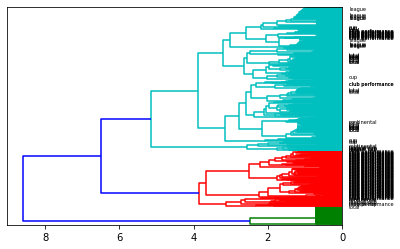

In [1173]:
from scipy.cluster.hierarchy import dendrogram, linkage
print(m.shape, len(tablecols))
dendrogram(
    linkage(df, method='complete'), 
    labels=[tc_name.get(tc)[0] for tc in tablecols],
    orientation='left',
)
None

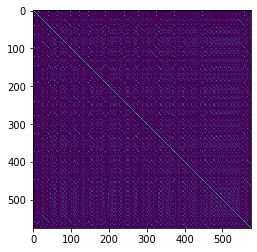

In [1174]:
%matplotlib inline
plt.imshow(df)

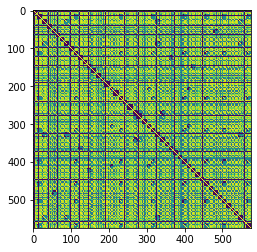

In [1175]:
%matplotlib inline
plt.imshow(m)